# Modelling and Evaluation Notebook

## Objectives

*   Answer business requirement 2: 
    * The client is interested to tell whether a given cell contains a malaria parasite or not.


## Inputs

* inputs/malaria_dataset/cell_images/train
* inputs/malaria_dataset/cell_images/test
* inputs/malaria_dataset/cell_images/validation
* image shape embeddings.

## Outputs
* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.




## Additional Comments | Insights | Conclusions




---

---

# Import regular packages

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Set Working Directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/malaria-detectector/jupyter_notebooks'

In [4]:
os.chdir(os.path.dirname(current_dir))
print('The current directory is setup.')

The current directory is setup.


In [6]:
work_dir = os.getcwd()
work_dir

'/workspace/malaria-detectector'

---

## Set input directories

Set train, validation and test paths

In [7]:
my_data_dir = 'inputs/malaria_dataset/cell_images'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [8]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Output directory already exists. create a new directory')
    pass
else:
    os.makedirs(name=file_path)

Output directory already exists. create a new directory


## Set labels

In [9]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['Parasitized', 'Uninfected']


## Set image shape

In [10]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(129, 129, 3)

---

# Number of images in train, test and validation data

* train - Parasitized: 3950 images
* train - Uninfected: 3950 images
* validation - Parasitized: 564 images
* validation - Uninfected: 564 images
* test - Parasitized: 1129 images
* test - Uninfected: 1129 images




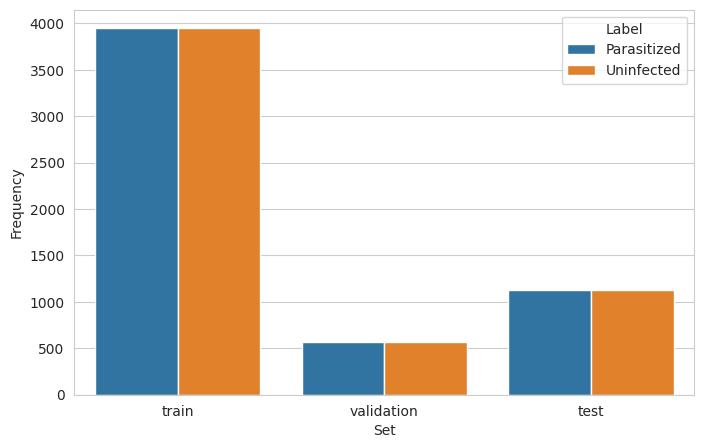

In [11]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image data augmentation

---

### ImageDataGenerator

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* ### Initialize ImageDataGenerator

In [20]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

* ### Augment training image dataset

In [21]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 7900 images belonging to 2 classes.


{'Parasitized': 0, 'Uninfected': 1}

* ### Augment validation image dataset

In [22]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 1128 images belonging to 2 classes.


{'Parasitized': 0, 'Uninfected': 1}

* ### Augment test image dataset

In [23]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 2258 images belonging to 2 classes.


{'Parasitized': 0, 'Uninfected': 1}

## Plot augmented training image

(20, 129, 129, 3)


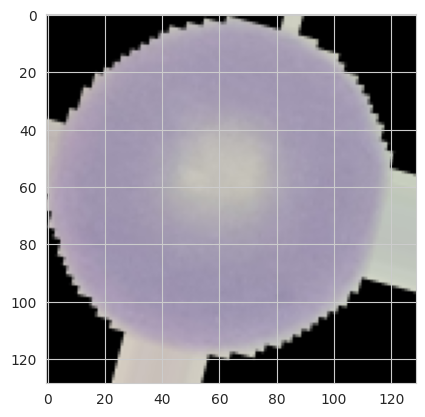

(20, 129, 129, 3)


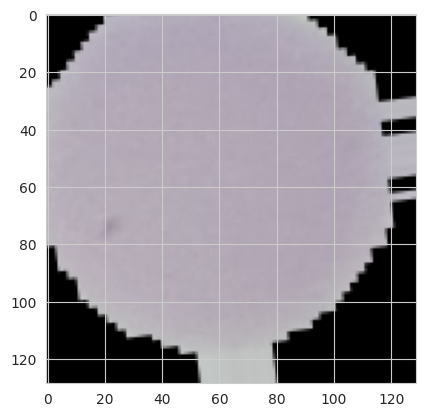

(20, 129, 129, 3)


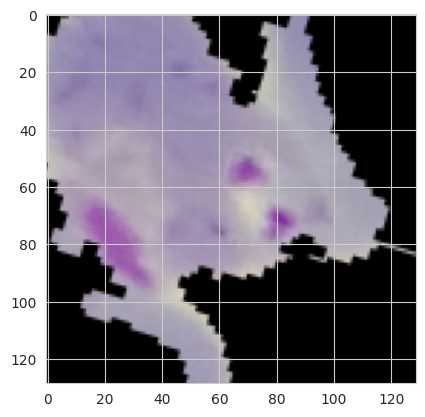

In [24]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

## Plot augmented validation and test images

(20, 129, 129, 3)


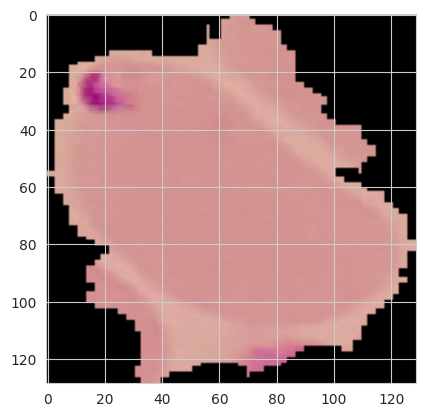

(20, 129, 129, 3)


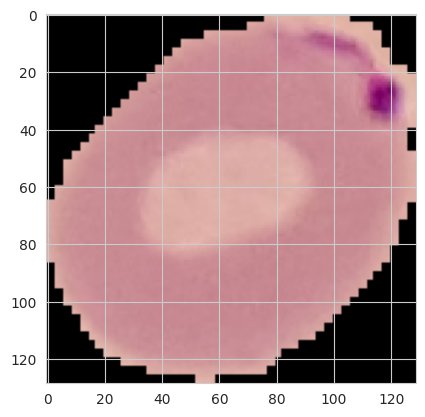

(20, 129, 129, 3)


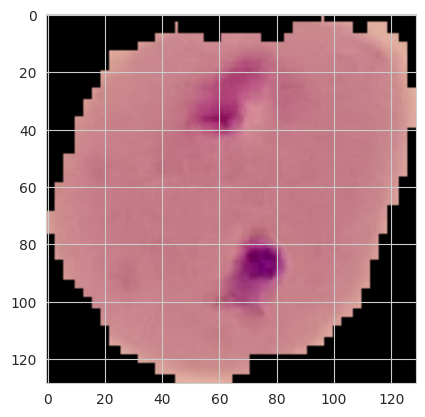

In [25]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()


(20, 129, 129, 3)


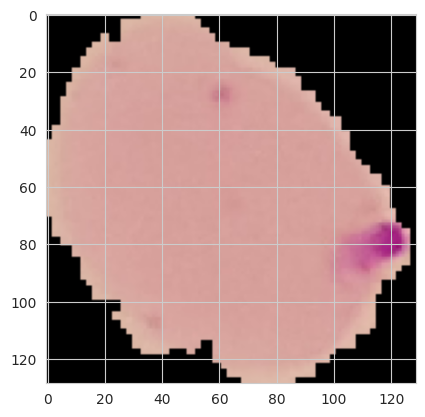

(20, 129, 129, 3)


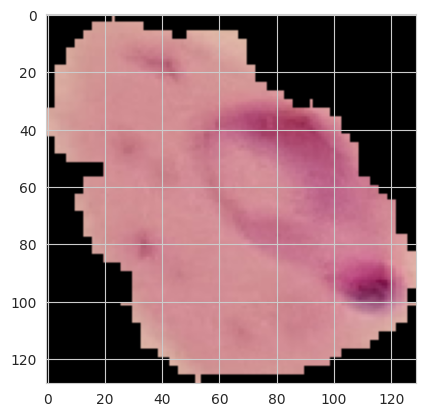

(20, 129, 129, 3)


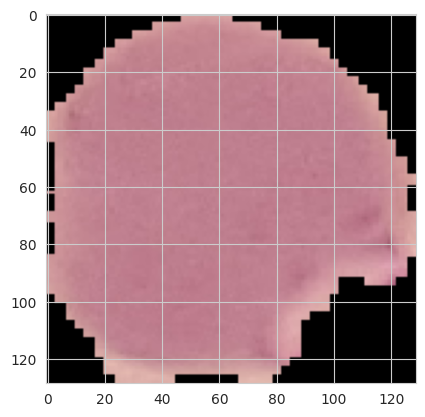

In [26]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()


## Save class_indices

In [19]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Model creation

---

## ML model

* ### Import model packages

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model 

In [14]:

def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

* ### Model Summary 

In [15]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

2024-10-05 13:48:11.463269: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


* ### Early Stopping 

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

## Fit model for model training

In [27]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )


2024-10-05 13:50:36.157031: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
395/395 [==============================] - 186s 471ms/step - loss: 0.6073 - accuracy: 0.6581 - val_loss: 0.3962 - val_accuracy: 0.9229
Epoch 2/25
395/395 [==============================] - 184s 466ms/step - loss: 0.3169 - accuracy: 0.9081 - val_loss: 0.2053 - val_accuracy: 0.9309
Epoch 3/25
395/395 [==============================] - 184s 465ms/step - loss: 0.1952 - accuracy: 0.9425 - val_loss: 0.1057 - val_accuracy: 0.9743
Epoch 4/25
395/395 [==============================] - 184s 467ms/step - loss: 0.1695 - accuracy: 0.9504 - val_loss: 0.1410 - val_accuracy: 0.9601
Epoch 5/25
395/395 [==============================] - 194s 491ms/step - loss: 0.1537 - accuracy: 0.9566 - val_loss: 0.0931 - val_accuracy: 0.9707
Epoch 6/25
395/395 [==============================] - 184s 467ms/step - loss: 0.1553 - accuracy: 0.9562 - val_loss: 0.0834 - val_accuracy: 0.9796
Epoch 7/25
395/395 [==============================] - 183s 464ms/step - loss: 0.1496 - accuracy: 0.9573 - val_loss: 0.0783 -

## Save model

In [28]:
model.save('outputs/v1/malaria_detector_model.h5')

---

# Model Performace

---

## Model learning curve

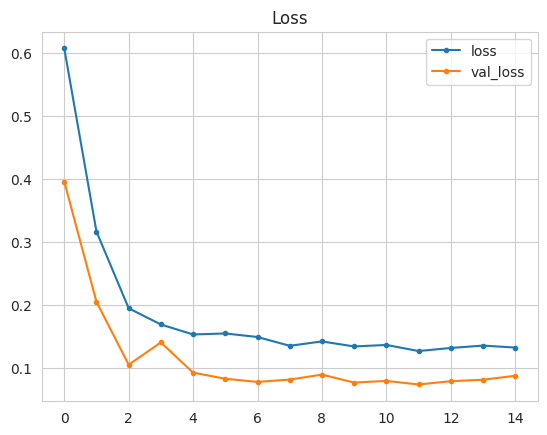

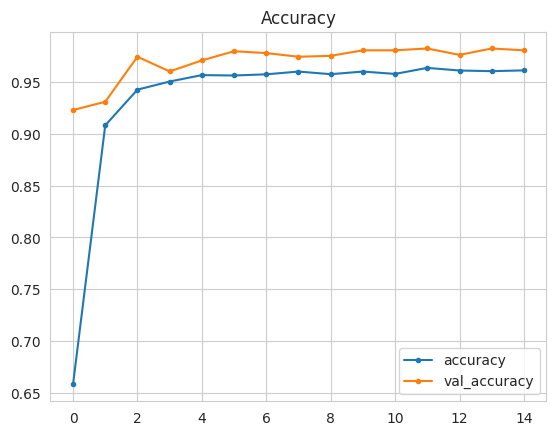

In [29]:

losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()


## Model Evaluation

Load saved model

In [30]:
from keras.models import load_model
model = load_model('outputs/v1/malaria_detector_model.h5')

Evaluate model on test set

In [31]:
evaluation = model.evaluate(test_set)

113/113 [==============================] - 13s 111ms/step - loss: 0.1044 - accuracy: 0.9663


### Save evaluation pickle

In [32]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Predict on new data

Load a random image as PIL

Image shape: (129, 129), Image mode: RGB


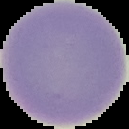

In [36]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[1]  # select Uninfected or Parasitised

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [37]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 129, 129, 3)


Predict class probabilities

In [38]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.961643
Uninfected
